In [1]:
# libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from pprint import pprint

from scipy.stats import uniform as sp_rand

In [2]:
# Load sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.cluster import KMeans

from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

In [3]:
# Get WD
working_directory = os.getcwd()
print(working_directory)

/Users/dperond/Repositories/maizegxeprediction2022/workspace/Daniel


In [4]:
# Initiate dataframe that will store rmse
evaluation_df = pd.DataFrame(columns=['model','condition', 'rmse', 'mape'])

# Meta+Hybrid+EC

In [5]:
# Set condition for next training
condition_name = "Meta+Hybrid+EC"

In [6]:
# Load training data
df = pd.read_csv("./data/training_Meta+Hybrid+EC.csv")
df.head()

,Env,Hybrid,Week_Planted,Yield_Mg_ha,hybrids_Parent1,hybrids_Parent2,meta_Latitude,meta_Longitude,meta_Previous_Crop,meta_Tillage_method,...,ec_LAI_pMatHar,ec_AccumulatedTT_pGerEme,ec_AccumulatedTT_pEmeEnJ,ec_AccumulatedTT_pEnJFlo,ec_AccumulatedTT_pFloFla,ec_AccumulatedTT_pFlaFlw,ec_AccumulatedTT_pFlwStG,ec_AccumulatedTT_pStGEnG,ec_AccumulatedTT_pEnGMat,ec_AccumulatedTT_pMatHar
0,DEH1_2014,M0088/LH185,19,5.721725,691.0,15.0,38.637405,-75.204048,9,21,...,0.205764,49.504228,193.031359,298.945606,568.505726,901.267505,991.957052,1310.703432,1568.706763,1576.874263
1,DEH1_2014,M0143/LH185,19,11.338246,702.0,15.0,38.637405,-75.204048,9,21,...,0.205764,49.504228,193.031359,298.945606,568.505726,901.267505,991.957052,1310.703432,1568.706763,1576.874263
2,DEH1_2014,M0003/LH185,19,6.540810,653.0,15.0,38.637405,-75.204048,9,21,...,0.205764,49.504228,193.031359,298.945606,568.505726,901.267505,991.957052,1310.703432,1568.706763,1576.874263
3,DEH1_2014,M0035/LH185,19,10.366857,669.0,15.0,38.637405,-75.204048,9,21,...,0.205764,49.504228,193.031359,298.945606,568.505726,901.267505,991.957052,1310.703432,1568.706763,1576.874263
4,DEH1_2014,M0052/LH185,19,10.908814,677.0,15.0,38.637405,-75.204048,9,21,...,0.205764,49.504228,193.031359,298.945606,568.505726,901.267505,991.957052,1310.703432,1568.706763,1576.874263


(71779, 775)
(16907, 775)


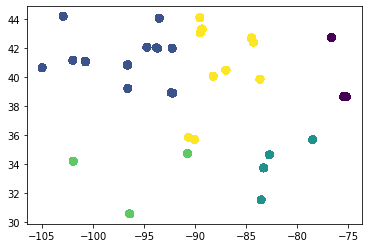

In [7]:
# Hold 2018 for test [ONLY FOR DEVELOPMENT!!!!]
train = df[df['Env'].str.split('_').str[-1] != "2018"]
test = df[df['Env'].str.split('_').str[-1] == "2018"]

print(train.shape)
print(test.shape)



# Select X and y for train and test
X_train = train.drop(columns=['Yield_Mg_ha','Env','Hybrid'], axis=1)
y_train = train['Yield_Mg_ha']

X_test = test.drop(columns=['Yield_Mg_ha','Env','Hybrid'], axis=1)
y_test = test['Yield_Mg_ha']


# KMeans to group sites by location

spatial_cv = []
for i in range(X_train.shape[0]):
    latlong = [X_train.iloc[i]['meta_Latitude'], X_train.iloc[i]['meta_Longitude']]
    spatial_cv.append(latlong)

kmeans = KMeans(n_clusters=5)
kmeans.fit(spatial_cv)
y_kmeans = kmeans.predict(spatial_cv)

plt.scatter(X_train['meta_Longitude'], X_train['meta_Latitude'], c=y_kmeans, s=50, cmap='viridis')



# Spatial Cross Validation with K-Fold
groupKFold = GroupKFold(n_splits=5) 

site_KFold = groupKFold.split(X=X_train, y=y_train, groups=y_kmeans)

train_indices, test_indices = [list(traintest) for traintest in zip(*site_KFold)]

countyCV = [*zip(train_indices, test_indices)]



# Random KFold
cv_randomkfold = KFold(n_splits=5)

# Spatial KFold
cv_spatialkfold = countyCV


# Standardize data
X_train_colums = X_train.columns
X_test_colums = X_test.columns

scaler = StandardScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train_colums)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train_colums)

In [8]:
# ################################
# ### Support Vector Regressor ###
# ################################

# model_name = "SVR"
# model = SVR()

# # Create the random grid
# random_grid = [
#     {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
#     {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
# ]

# # Using MSE instead of R2 for SVR
# scorer = make_scorer(mean_squared_error, greater_is_better=False)

# # Random search of parameters
# model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, random_state=42, n_jobs=-1, scoring=scorer, cv=cv_strategy)

# # Fit the random search model
# model_random.fit(X_train_scaled, y_train)
# pprint(model_random.best_params_)

# # Get best model
# best_random = model_random.best_estimator_

# # Predict onhel-out data with the best model
# best_random_predicted = best_random.predict(X_test_scaled)

# # Calculate metrics
# mape = mean_absolute_percentage_error(y_true=y_test, y_pred=best_random_predicted)
# rmse = mean_squared_error(y_true=y_test, y_pred=best_random_predicted, squared=False)

# # Append new metrics to evaluation dataframe
# evaluation_df = pd.concat([evaluation_df, pd.DataFrame({'model': model_name, 'condition': condition_name, 'set':cv_strategy_name, 'rmse': rmse, 'mape': mape}, index=[0])], ignore_index=True)

In [9]:
# Cross-validation strategy: KFold
cv_strategy = cv_randomkfold
cv_strategy_name = "Random-KFold"

In [10]:
################################
### Random Forest Regressor ####
################################

model_name = "Random Forest"
model = RandomForestRegressor(n_jobs = -1)

# Create the random grid
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, random_state=42, cv=cv_strategy)

# Fit the random search model
model_random.fit(X_train_scaled, y_train)
pprint(model_random.best_params_)

# Get best model
best_random = model_random.best_estimator_

# Predict onhel-out data with the best model
best_random_predicted = best_random.predict(X_test_scaled)

# Calculate metrics
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=best_random_predicted)
rmse = mean_squared_error(y_true=y_test, y_pred=best_random_predicted, squared=False)

# Append new metrics to evaluation dataframe
evaluation_df = pd.concat([evaluation_df, pd.DataFrame({'model': model_name, 'condition': condition_name, 'set':cv_strategy_name, 'rmse': rmse, 'mape': mape}, index=[0])], ignore_index=True)

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}


In [11]:
################################
### Lasso ######################
################################

model_name = "Lasso"
model = Lasso(tol=0.1)

# Create the random grid
random_grid = {
    'alpha':  sp_rand()
}

# Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, random_state=42, cv=cv_strategy)

# Fit the random search model
model_random.fit(X_train_scaled, y_train)
pprint(model_random.best_params_)

# Get best model
best_random = model_random.best_estimator_

# Predict onhel-out data with the best model
best_random_predicted = best_random.predict(X_test_scaled)

# Calculate metrics
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=best_random_predicted)
rmse = mean_squared_error(y_true=y_test, y_pred=best_random_predicted, squared=False)

# Append new metrics to evaluation dataframe
evaluation_df = pd.concat([evaluation_df, pd.DataFrame({'model': model_name, 'condition': condition_name, 'set':cv_strategy_name, 'rmse': rmse, 'mape': mape}, index=[0])], ignore_index=True)

{'alpha': 0.05808361216819946}


In [12]:
# # Cross-validation strategy: Spatial KFold
# cv_strategy = cv_spatialkfold
# cv_strategy_name = "Spatial-KFold"

In [13]:
# ################################
# ### Random Forest Regressor ####
# ################################

# model_name = "Random Forest"
# model = RandomForestRegressor(n_jobs = -1)

# # Create the random grid
# random_grid = {
#     'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
#     'max_features': ['log2', 'sqrt'],
#     'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Random search of parameters
# model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, random_state=42, cv=cv_strategy)

# # Fit the random search model
# model_random.fit(X_train_scaled, y_train)
# pprint(model_random.best_params_)

# # Get best model
# best_random = model_random.best_estimator_

# # Predict onhel-out data with the best model
# best_random_predicted = best_random.predict(X_test_scaled)

# # Calculate metrics
# mape = mean_absolute_percentage_error(y_true=y_test, y_pred=best_random_predicted)
# rmse = mean_squared_error(y_true=y_test, y_pred=best_random_predicted, squared=False)

# # Append new metrics to evaluation dataframe
# evaluation_df = pd.concat([evaluation_df, pd.DataFrame({'model': model_name, 'condition': condition_name, 'set':cv_strategy_name, 'rmse': rmse, 'mape': mape}, index=[0])], ignore_index=True)

In [14]:
# ################################
# ### Lasso ######################
# ################################

# model_name = "Lasso"
# model = Lasso(tol=0.1)

# # Create the random grid
# random_grid = {
#     'alpha':  sp_rand()
# }

# # Random search of parameters
# model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, random_state=42, cv=cv_strategy)

# # Fit the random search model
# model_random.fit(X_train_scaled, y_train)
# pprint(model_random.best_params_)

# # Get best model
# best_random = model_random.best_estimator_

# # Predict onhel-out data with the best model
# best_random_predicted = best_random.predict(X_test_scaled)

# # Calculate metrics
# mape = mean_absolute_percentage_error(y_true=y_test, y_pred=best_random_predicted)
# rmse = mean_squared_error(y_true=y_test, y_pred=best_random_predicted, squared=False)

# # Append new metrics to evaluation dataframe
# evaluation_df = pd.concat([evaluation_df, pd.DataFrame({'model': model_name, 'condition': condition_name, 'set':cv_strategy_name, 'rmse': rmse, 'mape': mape}, index=[0])], ignore_index=True)

# Meta+Hybrid+Weather

In [15]:
# Set condition for next training
condition_name = "Meta+Hybrid+Weather"

In [16]:
# Load training data
df = pd.read_csv("./data/training_Meta+Hybrid+Weather.csv")
df.head()

,Env,Hybrid,Week_Planted,Yield_Mg_ha,hybrids_Parent1,hybrids_Parent2,meta_Latitude,meta_Longitude,meta_Previous_Crop,meta_Tillage_method,...,weather_WS2M_Week41,weather_WS2M_Week42,weather_WS2M_Week43,weather_WS2M_Week44,weather_WS2M_Week5,weather_WS2M_Week52,weather_WS2M_Week6,weather_WS2M_Week7,weather_WS2M_Week8,weather_WS2M_Week9
0,DEH1_2014,M0088/LH185,19,5.721725,691.0,15.0,38.637405,-75.204048,9,21,...,2.955714,3.747143,3.514286,3.774286,2.744286,2.577143,2.677143,3.997143,3.22,2.785714
1,DEH1_2014,M0143/LH185,19,11.338246,702.0,15.0,38.637405,-75.204048,9,21,...,2.955714,3.747143,3.514286,3.774286,2.744286,2.577143,2.677143,3.997143,3.22,2.785714
2,DEH1_2014,M0003/LH185,19,6.540810,653.0,15.0,38.637405,-75.204048,9,21,...,2.955714,3.747143,3.514286,3.774286,2.744286,2.577143,2.677143,3.997143,3.22,2.785714
3,DEH1_2014,M0035/LH185,19,10.366857,669.0,15.0,38.637405,-75.204048,9,21,...,2.955714,3.747143,3.514286,3.774286,2.744286,2.577143,2.677143,3.997143,3.22,2.785714
4,DEH1_2014,M0052/LH185,19,10.908814,677.0,15.0,38.637405,-75.204048,9,21,...,2.955714,3.747143,3.514286,3.774286,2.744286,2.577143,2.677143,3.997143,3.22,2.785714


(98629, 190)
(19520, 190)


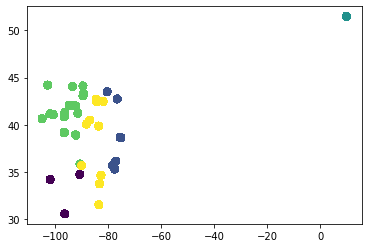

In [17]:
# Hold 2018 for test [ONLY FOR DEVELOPMENT!!!!]
train = df[df['Env'].str.split('_').str[-1] != "2018"]
test = df[df['Env'].str.split('_').str[-1] == "2018"]

print(train.shape)
print(test.shape)



# Select X and y for train and test
X_train = train.drop(columns=['Yield_Mg_ha','Env','Hybrid'], axis=1)
y_train = train['Yield_Mg_ha']

X_test = test.drop(columns=['Yield_Mg_ha','Env','Hybrid'], axis=1)
y_test = test['Yield_Mg_ha']


# KMeans to group sites by location

spatial_cv = []
for i in range(X_train.shape[0]):
    latlong = [X_train.iloc[i]['meta_Latitude'], X_train.iloc[i]['meta_Longitude']]
    spatial_cv.append(latlong)

kmeans = KMeans(n_clusters=5)
kmeans.fit(spatial_cv)
y_kmeans = kmeans.predict(spatial_cv)

plt.scatter(X_train['meta_Longitude'], X_train['meta_Latitude'], c=y_kmeans, s=50, cmap='viridis')



# Spatial Cross Validation with K-Fold
groupKFold = GroupKFold(n_splits=5) 

site_KFold = groupKFold.split(X=X_train, y=y_train, groups=y_kmeans)

train_indices, test_indices = [list(traintest) for traintest in zip(*site_KFold)]

countyCV = [*zip(train_indices, test_indices)]



# Random KFold
cv_randomkfold = KFold(n_splits=5)

# Spatial KFold
cv_spatialkfold = countyCV


# Standardize data
X_train_colums = X_train.columns
X_test_colums = X_test.columns

scaler = StandardScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train_colums)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train_colums)

In [18]:
# Cross-validation strategy: KFold
cv_strategy = cv_randomkfold
cv_strategy_name = "Random-KFold"

In [19]:
################################
### Random Forest Regressor ####
################################

model_name = "Random Forest"
model = RandomForestRegressor(n_jobs = -1)

# Create the random grid
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, random_state=42, cv=cv_strategy)

# Fit the random search model
model_random.fit(X_train_scaled, y_train)
pprint(model_random.best_params_)

# Get best model
best_random = model_random.best_estimator_

# Predict onhel-out data with the best model
best_random_predicted = best_random.predict(X_test_scaled)

# Calculate metrics
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=best_random_predicted)
rmse = mean_squared_error(y_true=y_test, y_pred=best_random_predicted, squared=False)

# Append new metrics to evaluation dataframe
evaluation_df = pd.concat([evaluation_df, pd.DataFrame({'model': model_name, 'condition': condition_name, 'set':cv_strategy_name, 'rmse': rmse, 'mape': mape}, index=[0])], ignore_index=True)


{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}


In [20]:
################################
### Lasso ######################
################################

model_name = "Lasso"
model = Lasso(tol=0.1)

# Create the random grid
random_grid = {
    'alpha':  sp_rand()
}

# Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, random_state=42, cv=cv_strategy)

# Fit the random search model
model_random.fit(X_train_scaled, y_train)
pprint(model_random.best_params_)

# Get best model
best_random = model_random.best_estimator_

# Predict onhel-out data with the best model
best_random_predicted = best_random.predict(X_test_scaled)

# Calculate metrics
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=best_random_predicted)
rmse = mean_squared_error(y_true=y_test, y_pred=best_random_predicted, squared=False)

# Append new metrics to evaluation dataframe
evaluation_df = pd.concat([evaluation_df, pd.DataFrame({'model': model_name, 'condition': condition_name, 'set':cv_strategy_name, 'rmse': rmse, 'mape': mape}, index=[0])], ignore_index=True)

{'alpha': 0.3745401188473625}


# Meta+Hybrid+Soil

In [21]:
# Set condition for next training
condition_name = "Meta+Hybrid+Soil"

In [22]:
# Load training data
df = pd.read_csv("./data/training_Meta+Hybrid+Soil.csv")
df.head()

,Env,Hybrid,Week_Planted,Yield_Mg_ha,hybrids_Parent1,hybrids_Parent2,meta_Latitude,meta_Longitude,meta_Previous_Crop,meta_Tillage_method,...,soil_H_Sat,soil_K_Sat,soil_Ca_Sat,soil_Mg_Sat,soil_Na_Sat,soil_Mehlich_P_ppm_P,soil_Sand,soil_Silt,soil_Clay,soil_Texture
0,DEH1_2016,B110/DK3IIH6,17,13.192059,18.0,11.0,38.648202,-75.44606,9,107,...,59.0,5.0,26.0,10.0,0.0,157.0,75.0,13.0,12.0,5.0
1,DEH1_2016,B84/DK3IIH6,17,12.014817,62.0,11.0,38.648202,-75.44606,9,107,...,59.0,5.0,26.0,10.0,0.0,157.0,75.0,13.0,12.0,5.0
2,DEH1_2016,BSSSC0_026/DK3IIH6,17,8.676662,131.0,11.0,38.648202,-75.44606,9,107,...,59.0,5.0,26.0,10.0,0.0,157.0,75.0,13.0,12.0,5.0
3,DEH1_2016,BSSSC0_038/DK3IIH6,17,7.489631,137.0,11.0,38.648202,-75.44606,9,107,...,59.0,5.0,26.0,10.0,0.0,157.0,75.0,13.0,12.0,5.0
4,DEH1_2016,R229/DK3IIH6,17,9.086901,1580.0,11.0,38.648202,-75.44606,9,107,...,59.0,5.0,26.0,10.0,0.0,157.0,75.0,13.0,12.0,5.0


(65227, 32)
(9198, 32)


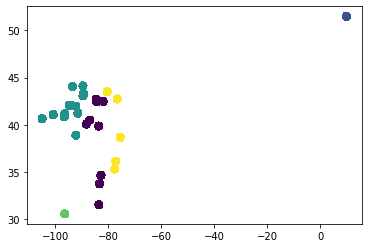

In [23]:
# Hold 2018 for test [ONLY FOR DEVELOPMENT!!!!]
train = df[df['Env'].str.split('_').str[-1] != "2018"]
test = df[df['Env'].str.split('_').str[-1] == "2018"]

print(train.shape)
print(test.shape)



# Select X and y for train and test
X_train = train.drop(columns=['Yield_Mg_ha','Env','Hybrid'], axis=1)
y_train = train['Yield_Mg_ha']

X_test = test.drop(columns=['Yield_Mg_ha','Env','Hybrid'], axis=1)
y_test = test['Yield_Mg_ha']


# KMeans to group sites by location

spatial_cv = []
for i in range(X_train.shape[0]):
    latlong = [X_train.iloc[i]['meta_Latitude'], X_train.iloc[i]['meta_Longitude']]
    spatial_cv.append(latlong)

kmeans = KMeans(n_clusters=5)
kmeans.fit(spatial_cv)
y_kmeans = kmeans.predict(spatial_cv)

plt.scatter(X_train['meta_Longitude'], X_train['meta_Latitude'], c=y_kmeans, s=50, cmap='viridis')



# Spatial Cross Validation with K-Fold
groupKFold = GroupKFold(n_splits=5) 

site_KFold = groupKFold.split(X=X_train, y=y_train, groups=y_kmeans)

train_indices, test_indices = [list(traintest) for traintest in zip(*site_KFold)]

countyCV = [*zip(train_indices, test_indices)]



# Random KFold
cv_randomkfold = KFold(n_splits=5)

# Spatial KFold
cv_spatialkfold = countyCV


# Standardize data
X_train_colums = X_train.columns
X_test_colums = X_test.columns

scaler = StandardScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train_colums)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train_colums)

In [24]:
# Cross-validation strategy: KFold
cv_strategy = cv_randomkfold
cv_strategy_name = "Random-KFold"

In [25]:
################################
### Random Forest Regressor ####
################################

model_name = "Random Forest"
model = RandomForestRegressor(n_jobs = -1)

# Create the random grid
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, random_state=42, cv=cv_strategy)

# Fit the random search model
model_random.fit(X_train_scaled, y_train)
pprint(model_random.best_params_)

# Get best model
best_random = model_random.best_estimator_

# Predict onhel-out data with the best model
best_random_predicted = best_random.predict(X_test_scaled)

# Calculate metrics
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=best_random_predicted)
rmse = mean_squared_error(y_true=y_test, y_pred=best_random_predicted, squared=False)

# Append new metrics to evaluation dataframe
evaluation_df = pd.concat([evaluation_df, pd.DataFrame({'model': model_name, 'condition': condition_name, 'set':cv_strategy_name, 'rmse': rmse, 'mape': mape}, index=[0])], ignore_index=True)


{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}


In [26]:
################################
### Lasso ######################
################################

model_name = "Lasso"
model = Lasso(tol=0.1)

# Create the random grid
random_grid = {
    'alpha':  sp_rand()
}

# Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, random_state=42, cv=cv_strategy)

# Fit the random search model
model_random.fit(X_train_scaled, y_train)
pprint(model_random.best_params_)

# Get best model
best_random = model_random.best_estimator_

# Predict onhel-out data with the best model
best_random_predicted = best_random.predict(X_test_scaled)

# Calculate metrics
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=best_random_predicted)
rmse = mean_squared_error(y_true=y_test, y_pred=best_random_predicted, squared=False)

# Append new metrics to evaluation dataframe
evaluation_df = pd.concat([evaluation_df, pd.DataFrame({'model': model_name, 'condition': condition_name, 'set':cv_strategy_name, 'rmse': rmse, 'mape': mape}, index=[0])], ignore_index=True)

{'alpha': 0.15599452033620265}


# Meta+Hybrid+EC+Weather+Soil

In [27]:
# Set condition for next training
condition_name = "Meta+Hybrid+EC+Weather+Soil"

In [28]:
# Load training data
df = pd.read_csv("./data/training_Meta+Hybrid+EC+Weather+Soil.csv")
df.head()

,Env,Hybrid,Week_Planted,Yield_Mg_ha,hybrids_Parent1,hybrids_Parent2,meta_Latitude,meta_Longitude,meta_Previous_Crop,meta_Tillage_method,...,soil_H_Sat,soil_K_Sat,soil_Ca_Sat,soil_Mg_Sat,soil_Na_Sat,soil_Mehlich_P_ppm_P,soil_Sand,soil_Silt,soil_Clay,soil_Texture
0,DEH1_2016,B110/DK3IIH6,17,13.192059,18.0,11.0,38.648202,-75.44606,9,107,...,59.0,5.0,26.0,10.0,0.0,157.0,75.0,13.0,12.0,5.0
1,DEH1_2016,B84/DK3IIH6,17,12.014817,62.0,11.0,38.648202,-75.44606,9,107,...,59.0,5.0,26.0,10.0,0.0,157.0,75.0,13.0,12.0,5.0
2,DEH1_2016,BSSSC0_026/DK3IIH6,17,8.676662,131.0,11.0,38.648202,-75.44606,9,107,...,59.0,5.0,26.0,10.0,0.0,157.0,75.0,13.0,12.0,5.0
3,DEH1_2016,BSSSC0_038/DK3IIH6,17,7.489631,137.0,11.0,38.648202,-75.44606,9,107,...,59.0,5.0,26.0,10.0,0.0,157.0,75.0,13.0,12.0,5.0
4,DEH1_2016,R229/DK3IIH6,17,9.086901,1580.0,11.0,38.648202,-75.44606,9,107,...,59.0,5.0,26.0,10.0,0.0,157.0,75.0,13.0,12.0,5.0


(49314, 977)
(9198, 977)


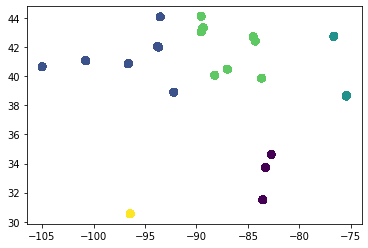

In [29]:
# Hold 2018 for test [ONLY FOR DEVELOPMENT!!!!]
train = df[df['Env'].str.split('_').str[-1] != "2018"]
test = df[df['Env'].str.split('_').str[-1] == "2018"]

print(train.shape)
print(test.shape)



# Select X and y for train and test
X_train = train.drop(columns=['Yield_Mg_ha','Env','Hybrid'], axis=1)
y_train = train['Yield_Mg_ha']

X_test = test.drop(columns=['Yield_Mg_ha','Env','Hybrid'], axis=1)
y_test = test['Yield_Mg_ha']


# KMeans to group sites by location

spatial_cv = []
for i in range(X_train.shape[0]):
    latlong = [X_train.iloc[i]['meta_Latitude'], X_train.iloc[i]['meta_Longitude']]
    spatial_cv.append(latlong)

kmeans = KMeans(n_clusters=5)
kmeans.fit(spatial_cv)
y_kmeans = kmeans.predict(spatial_cv)

plt.scatter(X_train['meta_Longitude'], X_train['meta_Latitude'], c=y_kmeans, s=50, cmap='viridis')



# Spatial Cross Validation with K-Fold
groupKFold = GroupKFold(n_splits=5) 

site_KFold = groupKFold.split(X=X_train, y=y_train, groups=y_kmeans)

train_indices, test_indices = [list(traintest) for traintest in zip(*site_KFold)]

countyCV = [*zip(train_indices, test_indices)]



# Random KFold
cv_randomkfold = KFold(n_splits=5)

# Spatial KFold
cv_spatialkfold = countyCV


# Standardize data
X_train_colums = X_train.columns
X_test_colums = X_test.columns

scaler = StandardScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train_colums)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train_colums)

In [30]:
# Cross-validation strategy: KFold
cv_strategy = cv_randomkfold
cv_strategy_name = "Random-KFold"

In [31]:
################################
### Random Forest Regressor ####
################################

model_name = "Random Forest"
model = RandomForestRegressor(n_jobs = -1)

# Create the random grid
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, random_state=42, cv=cv_strategy)

# Fit the random search model
model_random.fit(X_train_scaled, y_train)
pprint(model_random.best_params_)

# Get best model
best_random = model_random.best_estimator_

# Predict onhel-out data with the best model
best_random_predicted = best_random.predict(X_test_scaled)

# Calculate metrics
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=best_random_predicted)
rmse = mean_squared_error(y_true=y_test, y_pred=best_random_predicted, squared=False)

# Append new metrics to evaluation dataframe
evaluation_df = pd.concat([evaluation_df, pd.DataFrame({'model': model_name, 'condition': condition_name, 'set':cv_strategy_name, 'rmse': rmse, 'mape': mape}, index=[0])], ignore_index=True)


{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1200}


In [32]:
################################
### Lasso ######################
################################

model_name = "Lasso"
model = Lasso(tol=0.1)

# Create the random grid
random_grid = {
    'alpha':  sp_rand()
}

# Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, random_state=42, cv=cv_strategy)

# Fit the random search model
model_random.fit(X_train_scaled, y_train)
pprint(model_random.best_params_)

# Get best model
best_random = model_random.best_estimator_

# Predict onhel-out data with the best model
best_random_predicted = best_random.predict(X_test_scaled)

# Calculate metrics
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=best_random_predicted)
rmse = mean_squared_error(y_true=y_test, y_pred=best_random_predicted, squared=False)

# Append new metrics to evaluation dataframe
evaluation_df = pd.concat([evaluation_df, pd.DataFrame({'model': model_name, 'condition': condition_name, 'set':cv_strategy_name, 'rmse': rmse, 'mape': mape}, index=[0])], ignore_index=True)

{'alpha': 0.3745401188473625}


## Visualization

In [33]:
evaluation_df

,model,condition,rmse,mape,set
0,Random Forest,Meta+Hybrid+EC,2.372781,0.250839,Random-KFold
1,Lasso,Meta+Hybrid+EC,2.401448,0.250748,Random-KFold
2,Random Forest,Meta+Hybrid+Weather,2.702962,0.269789,Random-KFold
3,Lasso,Meta+Hybrid+Weather,2.719639,0.278576,Random-KFold
4,Random Forest,Meta+Hybrid+Soil,2.685516,0.278976,Random-KFold
5,Lasso,Meta+Hybrid+Soil,2.760293,0.290992,Random-KFold
6,Random Forest,Meta+Hybrid+EC+Weather+Soil,2.468136,0.250953,Random-KFold
7,Lasso,Meta+Hybrid+EC+Weather+Soil,2.702973,0.278410,Random-KFold


/Users/dperond/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/dperond/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/dperond/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/dperond/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


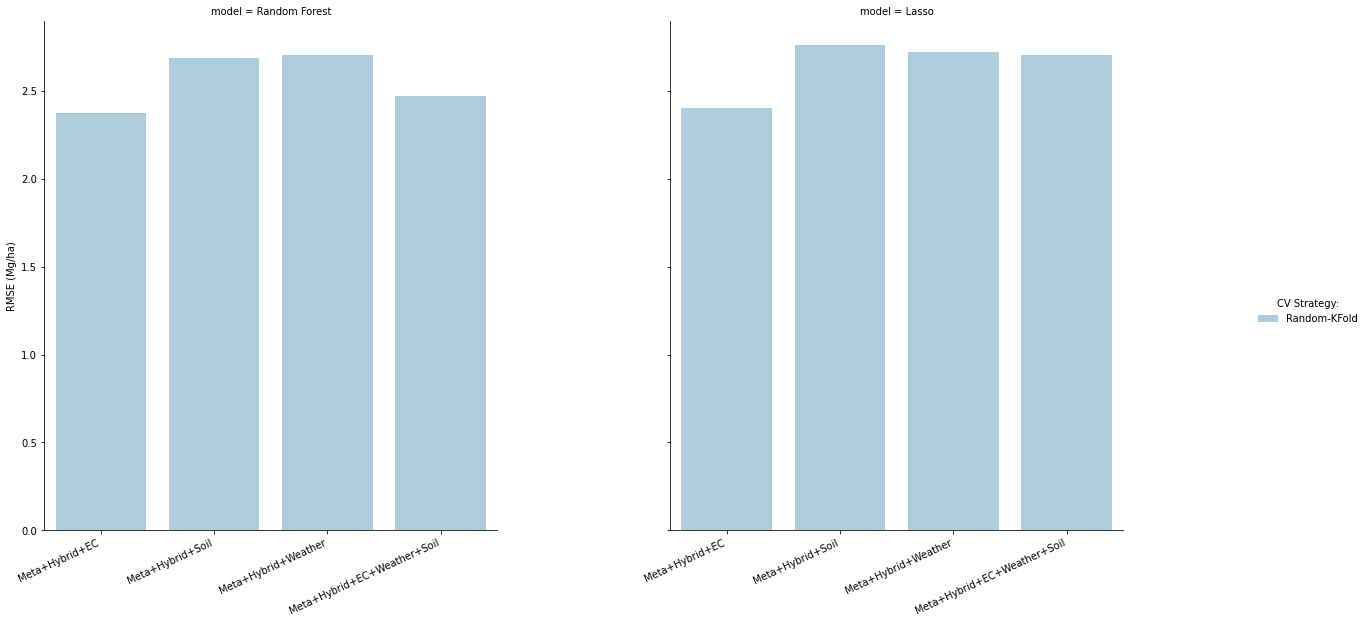

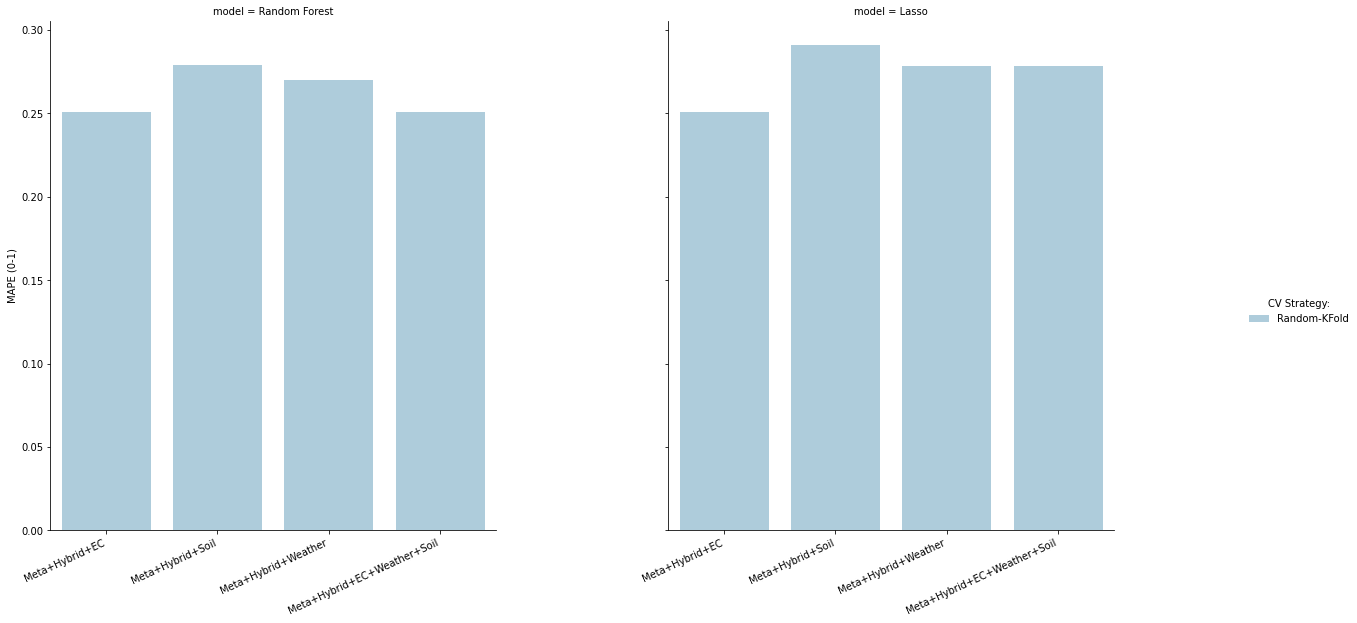

In [34]:
# RMSE
g = sns.FacetGrid(evaluation_df, col="model", height=8,  aspect=.5)
g = g.map(sns.barplot, "condition", "rmse", "set", palette="Paired", order=["Meta+Hybrid+EC","Meta+Hybrid+Soil","Meta+Hybrid+Weather","Meta+Hybrid+EC+Weather+Soil"], ci=68, hue_order=["Random-KFold"]).add_legend() # ,"Spatial-KFold"
g._legend.set_title("CV Strategy:")
g.set_axis_labels(y_var="RMSE (Mg/ha)", x_var="")
g.fig.set_figwidth(20)

for axes in g.axes.flat:          
    axes.set_xticklabels(axes.get_xticklabels(), rotation=25, horizontalalignment='right')


# MAPE 
g = sns.FacetGrid(evaluation_df, col="model", height=8,  aspect=.5)
g = g.map(sns.barplot, "condition", "mape", "set", palette="Paired", order=["Meta+Hybrid+EC","Meta+Hybrid+Soil","Meta+Hybrid+Weather","Meta+Hybrid+EC+Weather+Soil"], ci=68, hue_order=["Random-KFold"]).add_legend() # ,"Spatial-KFold"
g._legend.set_title("CV Strategy:")
g.set_axis_labels(y_var="MAPE (0-1)", x_var="")
g.fig.set_figwidth(20)

for axes in g.axes.flat:          
    axes.set_xticklabels(axes.get_xticklabels(), rotation=25, horizontalalignment='right')